In [ ]:
from nbdev import *
%nbdev_default_export hierarchy

Cells will be exported to pct.hierarchy,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_hide
%reload_ext autoreload
%autoreload 2

In [ ]:
# hide
import sys
sys.path.append("..")

# Hierarchy

Creation of Perceptual Control hierarchies.

In [ ]:
%nbdev_export
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np
from pct.nodes import PCTNode
from pct.functions import *
from pct.putils import UniqueNamer
from pct.putils import FunctionsList

In [ ]:
%nbdev_export
class PCTHierarchy():
    "A hierarchical perceptual control system, of PCTNodes."
    def __init__(self, levels=0, cols=0, pre=None, post=None, name="pcthierarchy", clear_names=True, links="single", history=False, build=True, **pargs):
        self.links_built = False
        self.order=None
        if clear_names:
            UniqueNamer.getInstance().clear()
        self.name=UniqueNamer.getInstance().get_name(name)
        if pre==None:
            self.preCollection=[]
        else:            
            self.preCollection=pre
        if post==None:
            self.postCollection=[]
        else:                 
            self.postCollection=post
        self.hierarchy = []
        for r in range(levels):
            col_list=[]
            for c in range(cols):
                if links == "dense":
                    if r > 0:
                        perc = WeightedSum(weights=np.ones(cols))
                    if r < levels-1:
                        ref = WeightedSum(weights=np.ones(cols))
                    if r == 0:
                        if levels > 1:
                            node = PCTNode(reference=ref, name=f'level{r}col{c}', history=history)      
                        else:
                            node = PCTNode(name=f'level{r}col{c}', history=history)                              
                    if r > 0 and r == levels-1:                        
                        node = PCTNode(perception=perc, name=f'level{r}col{c}', history=history)
                    if r > 0 and r < levels-1:
                        node = PCTNode(perception=perc, reference=ref, history=history, name=f'level{r}col{c}')

                else:
                    node = PCTNode(name=f'level{r}col{c}', history=history)
                
                if build:
                    node.build_links()                    
                    self.handle_perception_links(node, r, c, links)
                    self.handle_reference_links(node, r, c, links)
                col_list.append(node)
                
            self.hierarchy.append(col_list)
    
    
    def __call__(self, verbose=False):

        for func in self.preCollection:
            #if verbose:
            #    print(func.get_name(), end =" ")
            func(verbose)          

        if verbose:
            print()

        if self.order==None:
            for level in range(len(self.hierarchy)):
                for col in range(len(self.hierarchy[level])):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)
        elif self.order=="Down":
            for level in range(len(self.hierarchy)-1, -1, -1):
                for col in range(len(self.hierarchy[level])-1, -1, -1):
                    node  = self.hierarchy[level][col]
                    if verbose:
                        print(node.get_name(), end =" ")
                    node(verbose)                       
        else:
            for node_name in self.order:
                if verbose:
                    print(node_name, end =" ")
                FunctionsList.getInstance().get_function(node_name)(verbose)
        
        for func in self.postCollection:
            func(verbose)          

        if verbose:
            print()
        
        output = self.get_output_function().get_value()
        
        if verbose:
            print()
        
        return output
    
    
    def set_order(self, order):
        self.order=order
        
    def get_output_function(self):
        if len(self.postCollection) > 0:
            return self.postCollection[-1]
        
        return self.hierarchy[-1][-1].get_output_function()
        
    def add_preprocessor(self, func):
        self.preCollection.append(func)
        
    def add_postprocessor(self, func):
        self.postCollection.append(func)
 
    def run(self, steps=None, verbose=False):
        for i in range(steps):
            out = self(verbose)
        return out
    
    def get_node(self, level, col):
        return self.hierarchy[level][col]
    
    def handle_perception_links(self, node, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            node.add_link("perception", self.hierarchy[level-1][col].get_function("perception"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                node.add_link("perception", self.hierarchy[level-1][column].get_function("perception"))

    def handle_reference_links(self, thisnode, level, col, links_type):
        if level == 0 or links_type == None:
            return
        
        if links_type == "single":
            thatnode = self.hierarchy[level-1][col]
            thatnode.add_link("reference", thisnode.get_function("output"))
        
        if links_type == "dense":
            for column in range(len(self.hierarchy[level-1])):
                thatnode = self.hierarchy[level-1][column]
                thatnode.add_link("reference", thisnode.get_function("output"))

            
    def draw(self, with_labels=True,  font_size=12, font_weight='bold', node_color='red',  node_size=500, prog='dot',file=None):
        graph = self.graph()
        pos=graphviz_layout(graph, prog=prog)
        nx.draw(graph, pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight, 
                node_color=node_color,  node_size=node_size)
        
        if file != None:
            plt.title(self.name)
            plt.savefig(file)
            
    def graph(self):
        graph = nx.DiGraph()
        
        self.set_graph_data(graph)
                
        return graph
    
    def set_graph_data(self, graph):
        
        for func in self.preCollection:
            func.set_graph_data(graph)   
                    
        for level in range(len(self.hierarchy)):
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].set_graph_data(graph)
            
        for func in self.postCollection:
            func.set_graph_data(graph)  
            
        
    def summary(self, build=True):
        print(self.name, type(self).__name__)
                
        print("**************************")
        print("PRE:", end=" ")
        if len(self.preCollection) == 0:
            print("None")
        for func in self.preCollection:
            func.summary()   
        
            
        for level in range(len(self.hierarchy)):
            print(f'Level {level}')
            for col in range(len(self.hierarchy[level])):
                  self.hierarchy[level][col].summary(build=build)
            
        print("POST:", end=" ")
        if len(self.postCollection) == 0:
            print("None")
        for func in self.postCollection:
            func.summary()   


        print("**************************")
            
            
            
    def get_config(self):
        config = {"type": type(self).__name__,
                    "name": self.name}        
        
        pre = {}
        for i in range(len(self.preCollection)):
            pre[f'pre{i}']=self.preCollection[0].get_config()
        config['pre']=pre

        
        levels = {}
        for lvl in range(len(self.hierarchy)):
            level ={'level':lvl}
            columns={}
            for col in range(len(self.hierarchy[lvl])):
                column={'col':col}
                nodeconfig = self.hierarchy[lvl][col].get_config()
                #print(nodeconfig)
                column['node']=nodeconfig
                #print(column)
                columns[f'col{col}']=column
            level['nodes']=columns
            levels[f'level{lvl}']=level
        config['levels']=levels
        
        post = {}
        for i in range(len(self.postCollection)):
            post[f'post{i}']=self.postCollection[0].get_config()
        config['post']=post
        return config       

    
    @classmethod
    def from_config(cls, config):
        hpct = PCTHierarchy(name=config['name'])
        preCollection = []        
        coll_dict = config['pre']
        PCTNode.collection_from_config(preCollection, coll_dict)
        
        postCollection = []        
        coll_dict = config['post']
        PCTNode.collection_from_config(postCollection, coll_dict)
     
        hpct.preCollection=preCollection
        hpct.postCollection=postCollection
                
        hpct.hierarchy=[]
        for level_key in config['levels'].keys():
            cols = []
            for nodes_key in config['levels'][level_key]['nodes'].keys():
                node = PCTNode.from_config(config['levels'][level_key]['nodes'][nodes_key]['node'])
                cols.append(node)
            hpct.hierarchy.append(cols)
        
    
        return hpct
    

    def add_node(self, node, level=-1, col=-1):
        
        if len(self.hierarchy)==0:
            self.hierarchy.append([])

        if level<0 and col<0:
            self.hierarchy[0].append(node)
        else:
            levels = len(self.hierarchy)
            if level == levels:
                self.hierarchy.append([])      
            self.hierarchy[level].insert(col, node)
        
    def insert_function(self, level=None, col=None, collection=None, function=None, position=-1):
        self.hierarchy[level][col].insert_function(collection, function, position)

    def get_function(self, level=None, col=None, collection=None, position=-1):
        return self.hierarchy[level][col].get_function(collection, position)

    def set_links(self, func_name, *link_names):
        for link_name in link_names:
            FunctionsList.getInstance().get_function(func_name).add_link(FunctionsList.getInstance().get_function(link_name))

## Creating a Hierarchy

Create a hierarchy by defining the number of rows (levels) and columns.

In [ ]:
pre=Constant(5, name='precon')
post=Constant(10, name='postcon')
hpct = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, clear_names=False, links="dense")
hpct.hierarchy

[[<pct.nodes.PCTNode at 0x287d05da288>,

Create a hierarchy from a configuration.

In [ ]:
h = PCTHierarchy.from_config(hpct.get_config())

In [ ]:
assert h.get_config() == hpct.get_config()

## Viewing a Hierarchy

The hierarchy details can be viewed as a summary. 

In [ ]:
hpct.summary()

pcthierarchy1 PCTHierarchy
**************************
PRE: precon Constant | 5 
Level 0
level0col01 PCTNode
----------------------------
REF: weighted_sum4 WeightedSum | 0 | links  proportional7 proportional8 proportional9 
PER: variable2 Variable | 0 
COM: subtract4 Subtract | 0 | links  weighted_sum4 variable2 
OUT: proportional4 Proportional | gain 10 | 0 | links  subtract4 
----------------------------
level0col11 PCTNode
----------------------------
REF: weighted_sum5 WeightedSum | 0 | links  proportional7 proportional8 proportional9 
PER: variable3 Variable | 0 
COM: subtract5 Subtract | 0 | links  weighted_sum5 variable3 
OUT: proportional5 Proportional | gain 10 | 0 | links  subtract5 
----------------------------
level0col2 PCTNode
----------------------------
REF: weighted_sum6 WeightedSum | 0 | links  proportional7 proportional8 proportional9 
PER: variable4 Variable | 0 
COM: subtract6 Subtract | 0 | links  weighted_sum6 variable4 
OUT: proportional6 Proportional | gain 10 

The hierarchy details can be viewed as a configuration. That configuration can be used to create a hierarchy, as shown above.

In [ ]:
hpct.get_config()

{'type': 'PCTHierarchy',
 'name': 'pcthierarchy1',
 'pre': {'pre0': {'type': 'Constant',
   'name': 'precon',
   'value': 5,
   'links': {}}},
 'levels': {'level0': {'level': 0,
   'nodes': {'col0': {'col': 0,
     'node': {'type': 'PCTNode',
      'name': 'level0col01',
      'refcoll': {'0': {'type': 'WeightedSum',
        'name': 'weighted_sum4',
        'value': 0,
        'links': {0: 'proportional7', 1: 'proportional8', 2: 'proportional9'},
        'weights': array([1., 1., 1.])}},
      'percoll': {'0': {'type': 'Variable',
        'name': 'variable2',
        'value': 0,
        'links': {}}},
      'comcoll': {'0': {'type': 'Subtract',
        'name': 'subtract4',
        'value': 0,
        'links': {0: 'weighted_sum4', 1: 'variable2'}}},
      'outcoll': {'0': {'type': 'Proportional',
        'name': 'proportional4',
        'value': 0,
        'links': {0: 'subtract4'},
        'gain': 10}}}},
    'col1': {'col': 1,
     'node': {'type': 'PCTNode',
      'name': 'level0col1

Get the output function, which will be the output function of the last node, or the last item of the post-processor functions, if present.

In [ ]:
link = hpct.get_output_function()
print(link.get_config())

{'type': 'Constant', 'name': 'postcon', 'value': 10, 'links': {}}


The hierarhcy can also be viewed graphically as a network of connected nodes.

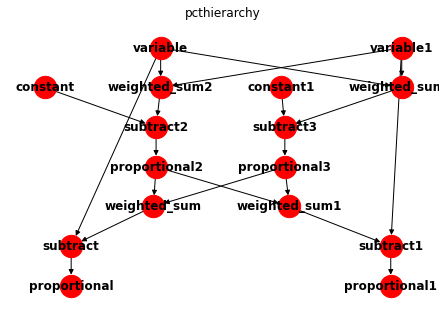

In [ ]:
ahpct = PCTHierarchy(2,2, links="dense")

test = 3
if test==1:
    g = ahpct.graph()
    pos=graphviz_layout(g, prog='dot')
    nx.draw(g, pos=pos, with_labels=True, font_size=12, font_weight='bold', node_color='red',  node_size=500)

if test ==2:
    g = ahpct.graph()
    pos = nx.multipartite_layout(g)
    nx.draw(g, pos=pos, with_labels=True, font_weight='bold', node_color='red',  node_size=500)

if test ==3:
    ahpct.draw()# file="ahpct.png", with_labels=True, font_weight='bold', node_color='red',  node_size=500, prog='dot'):


## Running a hierarchy

The hierachy can be run once by calling itself. The verbose flag will print the computations to the screen.

In [ ]:
hpct(verbose=True)

5.000 
level0col01 0.000 0.000 0.000 0.000 
level0col11 0.000 0.000 0.000 0.000 
level0col2 0.000 0.000 0.000 0.000 
level1col01 0.000 0.000 0.000 0.000 
level1col11 0.000 0.000 0.000 0.000 
level1col2 0.000 0.000 0.000 0.000 
level2col0 1.000 0.000 1.000 10.000 
level2col1 1.000 0.000 1.000 10.000 
level2col2 1.000 0.000 1.000 10.000 
10.000 



10

A hierarchy can be executed with the "run()" method, providing the number of iterations to run. 

In [ ]:
hpct1 = PCTHierarchy(3,3, pre=[pre], post=[post], history=True, links="dense")
hpct1.run(10)

10

## Viewing Data

If the hierarchy is created with the "history" flag equal to True, the data can be retrieved for each node. The node is accessed by specifying the row and column within the hierarchy. 

In [ ]:
print(hpct1.get_node(1,1).history.data)
assert hpct1.get_node(1,1).history.data == {'refcoll': {'weighted_sum6': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'percoll': {'weighted_sum5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'comcoll': {'subtract4': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'outcoll': {'proportional4': [0.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]}}

{'refcoll': {'weighted_sum6': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'percoll': {'weighted_sum5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, 'comcoll': {'subtract4': [0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0]}, 'outcoll': {'proportional4': [0.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]}}


## Examples


Build a hierarchy by adding nodes and functions manually.

Create an empty hierarchy.

In [ ]:
myhpct = PCTHierarchy()
myhpct.summary(build=False)

pcthierarchy PCTHierarchy
**************************
PRE: None
POST: None
**************************


Add a node. Then nodes at particular positions.

In [ ]:
myhpct.add_node(PCTNode())
myhpct.add_node(PCTNode(), level=1)
myhpct.add_node(PCTNode(), level=0)
myhpct.summary(build=False)

pcthierarchy PCTHierarchy
**************************
PRE: None
Level 0
pctnode2 PCTNode
----------------------------
REF: constant2 Constant | 1 
PER: variable2 Variable | 0 
COM: subtract2 Subtract | 0 
OUT: proportional2 Proportional | gain 10 | 0 
----------------------------
pctnode PCTNode
----------------------------
REF: constant Constant | 1 
PER: variable Variable | 0 
COM: subtract Subtract | 0 
OUT: proportional Proportional | gain 10 | 0 
----------------------------
Level 1
pctnode1 PCTNode
----------------------------
REF: constant1 Constant | 1 
PER: variable1 Variable | 0 
COM: subtract1 Subtract | 0 
OUT: proportional1 Proportional | gain 10 | 0 
----------------------------
POST: None
**************************


Replace functions at particular positions in the hierarchy.

In [ ]:
myhpct.insert_function(level=0, col=0, collection="perception", function=Proportional(3, name="prop2"))
myhpct.insert_function(level=1, col=0, collection="perception", function=WeightedSum(weights=np.ones(2), name="wsum"))
myhpct.insert_function(level=0, col=1, collection="reference", function=Proportional(1, name="passthru"))

Add pre and post processor functions.

In [ ]:
myhpct.add_preprocessor(Constant(1, name="cons1"))
myhpct.add_preprocessor(Proportional(5, name="prop1"))
myhpct.add_postprocessor(Proportional(5, name="postprop1"))
myhpct.add_postprocessor(Proportional(5, name="postprop2"))

Link the functions together.

In [ ]:
myhpct.set_links("prop1", "cons1")
myhpct.set_links("prop2", "prop1")
myhpct.set_links("wsum", "prop2", "variable")
myhpct.set_links("passthru", "proportional1")
myhpct.set_links("postprop1", "proportional")
myhpct.set_links("postprop2", "postprop1")

In [ ]:
myhpct.summary()

pcthierarchy PCTHierarchy
**************************
PRE: cons1 Constant | 1 
prop1 Proportional | gain 5 | 0 | links  cons1 
Level 0
pctnode2 PCTNode
----------------------------
REF: constant2 Constant | 1 
PER: prop2 Proportional | gain 3 | 0 | links  prop1 
COM: subtract2 Subtract | 0 | links  constant2 prop2 
OUT: proportional2 Proportional | gain 10 | 0 | links  subtract2 
----------------------------
pctnode PCTNode
----------------------------
REF: passthru Proportional | gain 1 | 0 | links  proportional1 
PER: variable Variable | 0 
COM: subtract Subtract | 0 | links  passthru variable 
OUT: proportional Proportional | gain 10 | 0 | links  subtract 
----------------------------
Level 1
pctnode1 PCTNode
----------------------------
REF: constant1 Constant | 1 
PER: wsum WeightedSum | 0 | links  prop2 variable 
COM: subtract1 Subtract | 0 | links  constant1 wsum 
OUT: proportional1 Proportional | gain 10 | 0 | links  subtract1 
----------------------------
POST: postprop1 Propor

Define the order in which the node will be processed.

In [ ]:
myhpct.set_order(["pctnode2", "pctnode1", "pctnode"])

Run the hierarchy once.

In [ ]:
out = myhpct(verbose=True)
print(out)
assert out == -35000

1.000 5.000 
pctnode2 1.000 15.000 -14.000 -140.000 
pctnode1 1.000 15.000 -14.000 -140.000 
pctnode -140.000 0.000 -140.000 -1400.000 
-7000.000 -35000.000 

-35000.0


In [ ]:
%nbdev_hide
from nbdev import *
notebook2script()

Converted 00_examples.ipynb.
Converted 01_putils.ipynb.
Converted 02_functions.ipynb.
Converted 03_nodes.ipynb.
Converted 04_hierarchy.ipynb.
Converted index.ipynb.
